# Проект для «Викишоп» c Bert

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Библиотеки" data-toc-modified-id="Библиотеки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Библиотеки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Векторизация" data-toc-modified-id="Векторизация-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Векторизация</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Создание-эмбединга-с-помощью-Bert" data-toc-modified-id="Создание-эмбединга-с-помощью-Bert-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Создание эмбединга с помощью Bert</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

### Библиотеки 

In [ ]:
!pip install imblearn -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from IPython.display import display
import seaborn as sns 
import math

from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer 
import nltk
from nltk.corpus import stopwords 
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from tqdm import tqdm
from tqdm import notebook
from joblib import Parallel, delayed

from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from transformers import pipeline
import torch

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import VotingClassifier
from nltk.corpus import wordnet
import warnings

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [5]:
RANDOM_STATE = 42
pd.set_option('display.max_colwidth', None)

In [6]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    print('smth wrong')

In [7]:
data.head(5)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [8]:
data.tail(5)

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0
159291,159450,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


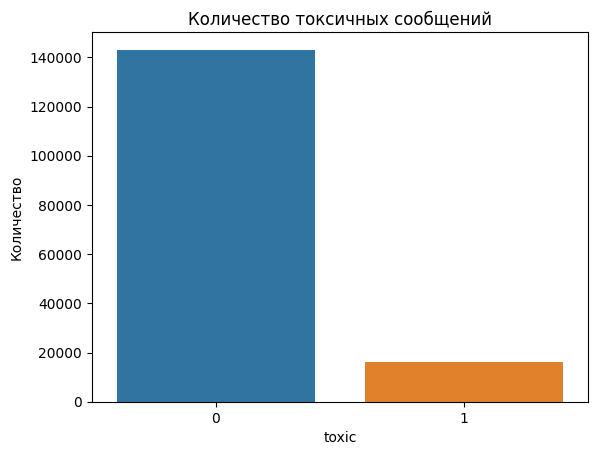

In [10]:
sns.countplot(data=data,x='toxic')
plt.title('Количество токсичных сообщений')
plt.ylabel('Количество')
plt.show()

In [11]:
data['toxic'].value_counts(normalize=True)*100

0    89.838787
1    10.161213
Name: toxic, dtype: float64

Количество строк 159292, пропуски отсутствуют, выражен дисбаланс классов

## Обучение

In [56]:
def clear_text(text):
    text=str(text)
    text = re.sub(r'https?:\/\/(?:www\.)?[^\s\/$.?#]+\.[^\s\/$.?#]+(?:\/[^\s]*)?|\s*\([Tt]alk\).*$|[^a-zA-Z]', 
                  ' ', 
                  text)
    return text

In [57]:
data['text_lem'] = data['text'].apply(clear_text)
data['text_lem'] = data['text_lem'].str.lower()

#### Лемматизация

In [11]:
nltk.download("wordnet")
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\baira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\baira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\baira\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [58]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [59]:
def le(text):
    doc = []
    token = nltk.word_tokenize(text)
    for word in token:
        doc.append(wnl.lemmatize(word,get_wordnet_pos(word)))
    return ' '.join(doc)

In [60]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [62]:
data.shape[0]/2

79646.0

In [63]:
data_balance = data.sample(79646)

In [64]:
data_balance['lemma'] = Parallel(n_jobs=-1,prefer="threads")(delayed(le)(t) for t in notebook.tqdm(data_balance['text_lem']))

  0%|          | 0/79646 [00:00<?, ?it/s]

In [65]:
data.head(5)

,Unnamed: 0,text,toxic,text_lem
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that s on


In [ ]:
# data_balance.to_csv("data_b.csv", index=False) 

In [30]:
data.shape

(159292, 4)

In [31]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
text_lem      0
dtype: int64

### Векторизация

In [32]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
data_balance['toxic'].value_counts()

0    71473
1     8173
Name: toxic, dtype: int64

In [29]:
X = data_balance['lemma']
y = data_balance['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
  test_size=0.25, 
  random_state=42,
  stratify=y)

In [30]:
[i.shape for i in [X_train, X_test, y_train, y_test]]

[(59734,), (19912,), (59734,), (19912,)]

### Pipeline

In [72]:
pipe_final = Pipeline([
    ('vect',   TfidfVectorizer(stop_words=list(stop_words),sublinear_tf=True,ngram_range=(1, 2))),
    # ('undersample', RandomUnderSampler(random_state=42)),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])
param_grid=[
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      class_weight='balanced',
                                      solver='saga',max_iter=1000)],
        'models__C':[0.1, 1, 10, 14],
        'models__penalty': ['l1', 'l2']
    },
    {    
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 9,], 
        'models__weights': ['uniform', 'distance'],  
        'models__metric': ['euclidean', 'minkowski'],  
    },
    {
        'models':[RandomForestClassifier(random_state=RANDOM_STATE
                                         , class_weight='balanced'
                                        )],
        'models__n_estimators':[500],
        'models__max_depth': [5,20],
        'models__min_samples_split': [2, 5]
    }
#     {
#         'models':[CatBoostClassifier(verbose=False,loss_function='Logloss'
#                                      , auto_class_weights='Balanced'
#                                     )],
#         'models__iterations': [50],
#         'models__learning_rate': [0.01, 0.1],
#         'models__depth': [4],
# #         'models__l2_leaf_reg': [1,3]
#    }
]

grid_search = HalvingGridSearchCV(
    pipe_final,
    param_grid,
    cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
    scoring='f1',
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train,y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['haven', 'now', 'up', 'how', 'are',
                                             'she', 'hers', 'me', 'very',
                                             'most', 'there', 'doesn',
                                             "they're", 'over', 'below', 'can',
                                             'itself', "i'd", 'other', 'did',
                                             "mightn't", 'off', 're', 'few',
                                             'at', "we'd", 'if', "haven't",
                                             'll', 'wouldn', ...],
                                 sublinear_tf=True)),
                ('models',
                 LogisticRegression(C=14, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='saga'))])
Метрика лучшей м

C:\Users\baira\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [101]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score',ascending=True).head(3)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__penalty,param_models__metric,...,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
34,2,59733,99.189596,71.118825,6.163101,0.586036,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,\n solver='saga')",14.0,l2,NaN,...,"{'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='saga'), 'models__C': 14, 'models__penalty': 'l2'}",0.757262,0.759606,0.758434,0.001172,1,0.997234,0.995936,0.996585,0.000649
33,2,59733,96.803169,72.479025,6.492841,0.442850,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,\n solver='saga')",10.0,l2,NaN,...,"{'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='saga'), 'models__C': 10, 'models__penalty': 'l2'}",0.756963,0.759306,0.758134,0.001172,2,0.996261,0.993513,0.994887,0.001374
32,2,59733,171.179939,1.340248,5.637415,0.254296,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,\n solver='saga')",1.0,l2,NaN,...,"{'models': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='saga'), 'models__C': 1, 'models__penalty': 'l2'}",0.729643,0.718102,0.723872,0.005770,3,0.941797,0.925364,0.933581,0.008217


In [81]:
y_pred = grid_search.predict(X_test)
print(f1_score(y_test,y_pred))

0.7720156555772995


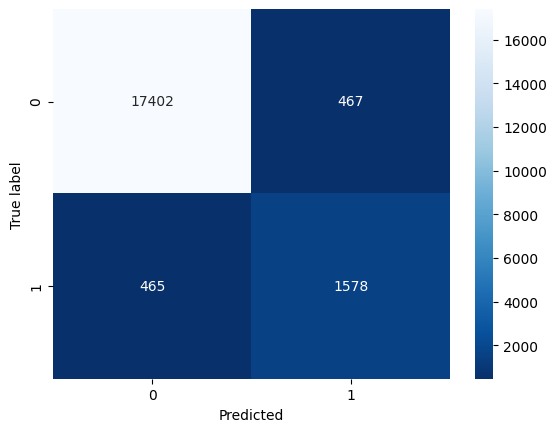

In [82]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

#### Вывод
Наилучшей результат покалаза модель
- LogisticRegression(C=14,penalty='l2', class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='saga')
- Метрика f1 на кросс валидации 0.758
- Метрика f1 на тестовой 0.77
- Достигнуть метрики не удалось, попробуем модель на Bert

### Создание эмбединга с помощью Bert

In [31]:
df = pd.read_csv('data_b.csv')

In [25]:
df.head(3)

,Unnamed: 0,text,toxic,text_lem,lemma
0,97584,"""\nI don't think that's necessary since those two buttons are in separate headings, which is clear enough for most users. Anyway, I've added some visual cues if the user hasn't filled in the corresponding textbox. [talk... contribs...] """,0,i don t think that s necessary since those two buttons are in separate headings which is clear enough for most users anyway i ve added some visual cues if the user hasn t filled in the corresponding textbox talk contribs,i don t think that s necessary since those two button be in separate heading which be clear enough for most user anyway i ve add some visual cue if the user hasn t fill in the correspond textbox talk contribs
1,91969,"As I have already stated on the R&I; article Talk page, I am not going to make any more edits to that article for the rest of the year. When the article was unlocked on February 1, I made a lot of progress on that article and it continued until Ramdrake recovered from a health issue and started obstructing progress again, and he did it with the backing of Slrubenstein. Slrubenstein has been hanging out on that article for over 6 years. If you want to do something useful to help Wikipedia I would suggest that you review the obstructive editing behavior of Ramdrake across a number of articles and also how his buddies like Slrubenstein and Wobble work with him.",0,as i have already stated on the r i article talk page i am not going to make any more edits to that article for the rest of the year when the article was unlocked on february i made a lot of progress on that article and it continued until ramdrake recovered from a health issue and started obstructing progress again and he did it with the backing of slrubenstein slrubenstein has been hanging out on that article for over years if you want to do something useful to help wikipedia i would suggest that you review the obstructive editing behavior of ramdrake across a number of articles and also how his buddies like slrubenstein and wobble work with him,a i have already state on the r i article talk page i be not go to make any more edits to that article for the rest of the year when the article be unlocked on february i make a lot of progress on that article and it continued until ramdrake recover from a health issue and start obstruct progress again and he do it with the backing of slrubenstein slrubenstein have be hang out on that article for over year if you want to do something useful to help wikipedia i would suggest that you review the obstructive edit behavior of ramdrake across a number of article and also how his buddy like slrubenstein and wobble work with him
2,42460,"Still, I regard this is another instance where I must ask some people not to shoot the messenger.",0,still i regard this is another instance where i must ask some people not to shoot the messenger,still i regard this be another instance where i must ask some people not to shoot the messenger


In [94]:
extractor = pipeline(
            tokenizer='google-bert/bert-base-uncased', 
            model="unitary/toxic-bert",
            task="feature-extraction",
            truncation=True,
            padding=True,
            framework="pt",
            device=0 if torch.cuda.is_available() else -1
            )
txtp = []


for tx in  notebook.tqdm(df['text_lem']):
    
    ext = extractor(tx, return_tensors="pt",truncation=True, padding=True)[0].numpy()[0] # это строка почему-то не работает в практикуме
    
    txtp.append(ext)


Device set to use cpu


  0%|          | 0/100 [00:00<?, ?it/s]

**Эмбединги были получены через google colab и экспортированы сюда**

In [95]:
# with open('txtp.txt', 'r') as f:
#     txtp = [line.strip() for line in f.readlines()]
# pp = ' '.join(txtp)

# list_contents = re.findall(r'\[(.*?)\]', pp) 
# result = [s.split() for s in list_contents]

# with open('y.txt', 'r') as f:
#     loaded_list = [line.strip() for line in f.readlines()]

# y_e = pd.Series(loaded_list).astype('int')

In [108]:
# for i,num in enumerate(result):
#     for j,numj in enumerate(num):
#         result[i][j] = float(numj)

In [112]:
X_train, X_test_1, y_train, y_test_1 = train_test_split(result, y_e, test_size=0.25, random_state=42
)

In [114]:
[len(i) for i in [X_train, X_test_1, y_train, y_test_1]]

[8250, 2750, 8250, 2750]

In [116]:
pipe_final = Pipeline([
    ('models', LogisticRegression())
])
param_grid=[
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced',solver='saga',penalty='l2',C=0.5,max_iter=1000)]
    },
    {
        'models':[RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': [None, 20],
        'models__min_samples_split': [2, 5]
    },   
    {    
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 9], 
        'models__weights': ['uniform', 'distance'],  
        'models__metric': ['euclidean', 'minkowski'],  
    },
    {
        'models':[CatBoostClassifier(verbose=100,loss_function='Logloss',auto_class_weights='Balanced',task_type="GPU", devices='0')],
        'models__iterations': [50],
        'models__learning_rate': [0.03, 0.1],
        'models__depth': [3,6],
        'models__l2_leaf_reg': [3]
   }
]

bert_s = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
    scoring='f1',
    n_jobs=3,
    error_score='raise'
)

bert_s.fit(X_train,y_train)

print('Лучшая модель и её параметры:\n\n', bert_s.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', bert_s.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models', KNeighborsClassifier(n_neighbors=9))])
Метрика лучшей модели на тренировочной выборке: 0.9168613441686134


In [118]:
pd.DataFrame(bert_s.cv_results_).sort_values(by='rank_test_score',ascending=True).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__weights,param_models__n_neighbors,param_models__metric,param_models,param_models__learning_rate,param_models__l2_leaf_reg,param_models__iterations,param_models__depth,param_models__min_samples_split,param_models__max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
8,0.496960,0.017099,3.325474,0.074095,uniform,9.0,minkowski,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,NaN,"{'models__weights': 'uniform', 'models__n_neighbors': 9, 'models__metric': 'minkowski', 'models': KNeighborsClassifier()}",0.911582,0.922141,0.916861,0.005280,1
9,9.876728,0.570757,0.290336,0.008369,NaN,NaN,NaN,"RandomForestClassifier(class_weight='balanced', random_state=42)",NaN,NaN,NaN,NaN,5.0,None,"{'models__min_samples_split': 5, 'models__max_depth': None, 'models': RandomForestClassifier(class_weight='balanced', random_state=42)}",0.905237,0.918984,0.912111,0.006874,2
0,0.464292,0.016580,2.222126,0.099568,uniform,5.0,minkowski,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,NaN,"{'models__weights': 'uniform', 'models__n_neighbors': 5, 'models__metric': 'minkowski', 'models': KNeighborsClassifier()}",0.911330,0.910628,0.910979,0.000351,3


Метрика на тестовых данных 0.8856088560885609


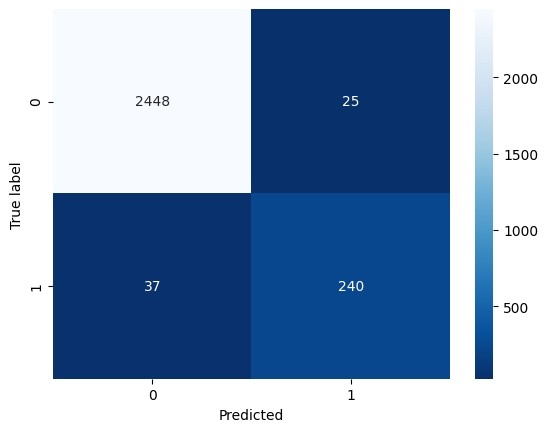

In [125]:
y_pred = bert_s.predict(X_test_1)
print(f"Метрика на тестовых данных {f1_score(y_test_1,y_pred)}")
cm = confusion_matrix(y_test_1,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Вывод:
Наилучший результат показала 
- KNeighborsClassifier(n_neighbors=9))])
- Метрика лучшей модели на тренировочной выборке: 0.9168613441686134
- Метрика f1 на тестовой 0.89

## Выводы

### Подготовка
- Количество записей 159291 
- Пропусков нет
- Присутствует дисбаланс классов 90% обычных сообщений, 10% токсичных
- Была проведена фильтрация сообщений и лемматизация

### Модель
Наилучшей результат покалаза модель обученная на эмбедингах

- KNeighborsClassifier(n_neighbors=9))])
- Метрика лучшей модели на тренировочной выборке: 0.91
- Метрика f1 на тестовой 0.89

Модель успешно обучена f1_score 0.91, что выше требуемого значения не меньше 0.75. Модель решает задачу бинарной классификации комментариев на позитивные и негативные. Для дальнейшего улучшения необходимо увеличить вычислительные мощности и уменьшить дисбаланс классов